**Table of contents**<a id='toc0_'></a>    
- [Visibility](#toc1_)    
  - [I. Usability elements](#toc1_1_)    
    - [I.1 Angle classes](#toc1_1_1_)    
    - [I.2 Interpolation](#toc1_1_2_)    
  - [II. Time](#toc1_2_)    
    - [II.1 Julian Day](#toc1_2_1_)    
    - [II.2 Time correction](#toc1_2_2_)    
    - [II.3 Sidereal Time](#toc1_2_3_)    
      - [II.3.1 At Greenwich](#toc1_2_3_1_)    
  - [III. Trajectory along the sky](#toc1_3_)    
    - [III.1 Coordinates](#toc1_3_1_)    
    - [III.2 Compute trajectory](#toc1_3_2_)    
      - [III.2.1 Precession](#toc1_3_2_1_)    
      - [III.2.2 Nutation](#toc1_3_2_2_)    
      - [III.2.3 Refraction](#toc1_3_2_3_)    
      - [III.2.4 Motion along the sky](#toc1_3_2_4_)    
  - [IV. Sun](#toc1_4_)    
    - [IV.I Twilight](#toc1_4_1_)    
  - [V. Moon](#toc1_5_)    
    - [V.I Moon Phases](#toc1_5_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Visibility](#toc0_)

## <a id='toc1_1_'></a>[I. Usability elements](#toc0_)

Import required packages 

In [200]:
## required packages
import os.path as ph
from os import getcwd
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

PROJECT_FOLDER = ph.split(getcwd())[0]
DATA_FOLDER = ph.join(PROJECT_FOLDER,'data')


### <a id='toc1_1_1_'></a>[I.1 Angle classes](#toc0_)

To handle the different formats in which one can express the value of an angle on celestial sphere (radiants, degrees, hours), two classes of object are defined. These keep the value of an angle in different units and provide some usefull function to convert from one format to an other.

In [201]:
## angle classes
class Angles():
    """Class to handle with angles in degrees or radiants.
    
    The class takes the value of an angle in deg or rad,
    converts one in other and stored the values.

    The format for values in deg is a `list` of length 2 `[[sign], [values]]`:
    
      * the first element is a `str` that keeps the sign of the angle

      * the second one is a `numpy.ndarray` of length 3: [deg, pri, sec.sec] 

    The attributes of the class are:

    :ivar rad: the value of the angle in radiants
    :vartype rad: float | None
    :ivar deg: the value of the angle in deg. The format is [sign, [deg,pp,ss.ss]]
    :vartype deg: list[str, np.ndarray]    
    :ivar lim: the angle is in a range set by [0,`lim`] (see `std_format()` docstring)
    :vartype lim: int

    .. note::
        It is possible to generate a null angle, that is an empty `Angles` variable
        (`self.deg = []` and `self.rad = None`), through the command `Angles(None)`. 

    :Example:

    >>> ang = Angles()
    """

    #: a dictionary to pass from string symbol to integer and vice versa
    strsign = { '+' :  1,
                '-' : -1,
                 1  : '+',
                -1  : '-' }

    @staticmethod
    def decimal(ang: np.ndarray | list) -> float:
        """Function to convert a list angle
        [val, val, val.val] in a float 
        val.val 

        :param ang: angle array value in deg or hms
        :type ang: np.ndarray | list
        
        :return: angle float value
        :rtype: float
        """
        if sum(ang) == 0: return 0
        else: return ang[0] + ang[1]/60 + ang[2]/3600
    
    @staticmethod
    def deg_to_rad(deg: float) -> float:
        """Function to convert deg in rad

        :param deg: list angle in deg
        :type deg: list

        :return: value in radiants
        :rtype: float
        """
        # computing radiants
        rad = deg * pi / 180
        return rad

    @staticmethod
    def rad_to_deg(rad: float) -> list:
        """Function to convert rad in deg

        :param rad: value in radiants
        :type rad: float
        :param lim: edge of the angle range, defaults to 360
        :type lim: int, optional
        
        :return: list angle in deg
        :rtype: list
        """
        # computing degrees
        deg = rad * 180 / pi
        return deg

    def __init__(self, ang: float | list | None, unit: str, lim: int = 360) -> None:
        """Constructor of the class

        The function takes a value (`ang`) and the corrisponding 
        unit (`unit`) as input, computes and stores the angle
        values in deg and rad. 

        :param ang: angle value
        :type ang: float | list
        :param unit: unit of angle value, like 'deg' or 'rad'
        :type unit: str
        :param lim: angle edge (see `std_format()` docstring), defaults to 360
        :type lim: int, optional
        """
        # setting lim
        self.lim = lim
        if ang is None:
            self.deg = None
            self.rad = None
        # value in radiants
        elif unit == 'rad':
            self.rad = ang
            self.deg = Angles.rad_to_deg(ang)
        # value in degrees
        elif unit == 'deg':
            # `ang` is a float
            if type(ang) == list:
                # getting the sign
                sign = Angles.strsign[ang[0]]
                self.deg = Angles.decimal(ang[1])*sign
            else:
                self.deg = ang
            self.rad = Angles.deg_to_rad(self.deg)

    def std_format(self) -> list:
        """Function to adjust format of a list angle in deg or hms.

        The wanted format is:

          - [`sign`, [deg (<`lim`), pp (<60), ss.ss (<60)]]

          - [`sign`, [hh, mm (<60), ss.ss (<60)]]

        It is possible to change the range of the angle: [0, `lim`]
          
        :param sign: sign of the angle
        :type sign: int | str
        :param ang: angle value
        :type ang: np.ndarray | list
        :param lim: the angle edge , defaults to 360
        :type lim: int | None, optional
        
        :return: correct format for the angle value
        :rtype: list
        """
        ang = self.deg
        if ang == 0.:
            return ['+',np.zeros(3,dtype=int)]
        else:
            lim = self.lim
            # taking the sign as a str
            sign = Angles.strsign[np.sign(ang)]
            # takeing the absolute value
            ang = abs(ang)
            if ang > lim:
                ang -= lim * (ang // lim)
            # degrees / hours
            val = [np.trunc(ang).astype(int)]
            # primes / minutes
            val += [np.trunc(ang % 1 * 60).astype(int)]
            # seconds
            val += [round(ang % 1 * 60 % 1 * 60,4)]
            return [sign, np.array(val)]



    def print_angle(self,sel: str = 'all') -> str:
        """Function to print the value of an angle
        in all units

        One can select to print the angle in all 
        units or just one through the `sel`
        parameter:

            - `sel = 'all'`: print value in all units
            - `sel = 'deg'`: print value in deg
            - `sel = 'rad'`: print value in rad

        :param sel: to select in which unit printing the angle, defaults to 'all'
        :type sel: str, optional

        :return: the string with the values
        :rtype: str
        """
        deg = self.std_format()
        deg_str = deg[0]+f'{deg[1]}'
        rad_str = f'{self.rad/pi} * pi'
       
        if sel == 'deg': return deg_str
        elif sel == 'rad': return rad_str
        elif sel == 'all': return 'deg =\t' + deg_str + '\nrad =\t' + rad_str
        else: raise Exception(f"!Error in `sel` parameter!\nsel = {sel} is not allowed\nRead the documentation for correct values of the parameter")

    def __add__(self, angle):
        """Function to sum two angles

        :param angle: second angle
        :type angle: Angles

        :return: sum of the angles
        :rtype: Angles
        """
        # check for edges
        if self.lim != angle.lim:
            print('\n!warning: you are summing angles with different limits!\nThe limit of the sum is taken equal to that of ang1\n')
        # computing the sum in rad
        sumrad = self.rad + angle.rad
        return Angles(ang=sumrad,unit='rad',lim=self.lim)

    def __sub__(self, angle):
        """Function to subtract two angles

        :param angle: second angle
        :type angle: Angles

        :return: subtraction of the angles
        :rtype: Angles
        """
        if self.lim != angle.lim:
            print('\n!warning: you are summing angles with different limits!\nThe limit of the sum is taken equal to that of ang1\n')
        subrad = self.rad - angle.rad
        return Angles(ang=subrad,unit='rad',lim=self.lim)

    def __mul__(self,val: float | int):
        """Function to implement the angle-number product

        :param val: a number
        :type val: float | int

        :return: angle-number product
        :rtype: Angles
        """
        return Angles(self.rad*val,'rad',lim=self.lim)
    
    def __neg__(self):
        return self * -1



class HAngles(Angles):
    """This is essentially the same class as :class: `Angles`, keeping in account 
    the description of an angle in [hours, minutes, seconds] format.

    The attributes are:

    :ivar rad: from :class: `Angles`; the value of the angle in radiants; 
    :vartype rad: float
    :ivar deg: from :class: `Angles`; the value of the angle in deg. The format is [sign, [deg,pp,ss.ss]] 
    :vartype deg: list[str, np.ndarray]    
    :ivar deg: the value of the angle in hms. The format is [sign, [hh,mm,ss.ss]]
    :vartype deg: list[str, np.ndarray]    
    :ivar lim: from :class: `Angles`; the angle is in a range set by [0,`lim`] (see `std_format()` docstring)
    :vartype lim: int
    """

    @staticmethod
    def deg_to_hms(deg: float) -> list:
        """Function to convert deg in hms

        1 hour = 15 degrees

        :param deg: list angle in deg
        :type deg: list

        :return: list angle in hms
        :rtype: list
        """
        hms = deg / 15
        return hms
    
    @staticmethod
    def hms_to_deg(hms: float) -> list:
        """Function to convert hms in deg

        1 hour = 15 degrees

        :param hms: list angle in hms
        :type hms: list
        :param lim: edge of the angle range, defaults to 360
        :type lim: int, optional

        :return: list angle in deg
        :rtype: list
        """
        deg = hms * 15
        return deg
    
    @staticmethod
    def rad_to_hms(rad: float) -> list:
        """Function to convert rad in hms

        It pass through the `rad_to_deg()` and
        `deg_to_hms()` functions

        :param rad: angle value in rad
        :type rad: float
        :param lim: edge of the angle range, defaults to 360
        :type lim: int, optional

        :return: list angle in hms
        :rtype: list
        """
        deg = Angles.rad_to_deg(rad)
        hms = HAngles.deg_to_hms(deg)
        return hms
    
    @staticmethod
    def hms_to_rad(hms: list) -> float:
        """Function to convert hms in rad

        It pass through the `hms_to_deg()` and
        `deg_to_rad()` functions

        :param rad: list angle in hms
        :type rad: list
        :param lim: edge of the angle range, defaults to 360
        :type lim: int, optional

        :return: angle value in rad 
        :rtype: float
        """
        deg = HAngles.hms_to_deg(hms)
        rad = Angles.deg_to_rad(deg)
        return rad
    
    def __init__(self, ang: float | list | None, unit: str, lim: int = 360):
        """Constructor of the class (inherited from :class: `Angles`)

        The function takes a value (`ang`) and the corrisponding 
        unit (`unit`) as input, computes and stores the angle
        values in deg, rad and hms. 

        :param ang: angle value
        :type ang: float | list
        :param unit: unit of angle value, like 'deg' or 'rad'
        :type unit: str
        :param lim: angle edge (see `std_format()` docstring), defaults to 360
        :type lim: int, optional
        """
        # `Angles.__init__()` function
        super().__init__(ang, unit, lim)
        if ang is None:
            self.hms = None
        # angle in hms
        elif unit == 'hms':
            # `ang` is a float
            if type(ang) == list:
                sign = ang[0]
                self.hms = Angles.decimal(ang[1])
            else:
                self.hms = ang
            self.deg = HAngles.hms_to_deg(self.hms)
            self.rad = HAngles.hms_to_rad(self.hms)
        # angle in rad or deg
        else:
            self.hms = HAngles.deg_to_hms(self.deg)

    def std_format(self, unit: str = 'deg') -> list:
        if unit == 'deg' or self.rad == 0.:
            return super().std_format()
        elif unit == 'hms':
            ang = self.hms
            lim = self.lim / 15
            # taking the sign as a str
            sign = Angles.strsign[np.sign(ang)]
            # takeing the absolute value
            ang = abs(ang)
            if ang > lim:
                ang -= lim * (ang // lim)
            # hours
            val = [np.trunc(ang).astype(int)]
            # minutes
            val += [np.trunc(ang % 1 * 60).astype(int)]
            # seconds
            val += [val[1] % 1 * 60]
            return [sign, np.array(val)]

    
    def print_angle(self, sel: str = 'all'):
        """Function to print the value of an angle
        in all units (inherited from :class: `Angles`)

        One can select to print the angle in all 
        units or just one through the `sel`
        parameter:

            - `sel = 'all'`: print value in all units
            - `sel = 'deg'`: print value in deg
            - `sel = 'rad'`: print value in rad
            - `sel = 'hms'`: print value in hms

        :param sel: to select in which unit printing the angle, defaults to 'all'
        :type sel: str, optional

        :return: the string with the values
        :rtype: str
        """
        hms = self.std_format('hms')
        hms_str = hms[0]+f'{hms[1]}'
        
        if sel == 'hms': return hms_str
        elif sel == 'all': return  super().print_angle(sel=sel) + '\nhms = \t' + hms_str
        else: return super().print_angle(sel=sel)

    def __add__(self, angle):
        """Function to sum two angles

        :param angle: second angle
        :type angle: Angles

        :return: sum of the angles
        :rtype: Angles
        """
        # check for edges
        if self.lim != angle.lim:
            print('-> Warning: you are summing angles with different limits!\nThe limit of the sum is taken equal to that of ang1\n')
        # computing 
        sumrad = self.rad + angle.rad
        return HAngles(ang=sumrad,unit='rad',lim=self.lim)

    def __sub__(self, angle):
        """Function to subtract two angles

        :param angle: second angle
        :type angle: HAngles

        :return: subtraction of the angles
        :rtype: HAngles
        """        
        if self.lim != angle.lim:
            print('-> Warning: you are summing angles with different limits!\nThe limit of the sum is taken equal to that of ang1\n')
        subrad = self.rad - angle.rad
        return HAngles(ang=subrad,unit='rad',lim=self.lim)

    def __mul__(self,val: float | int):
        """Function to implement the angle-number product

        :param val: a number
        :type val: float | int

        :return: angle-number product
        :rtype: HAngles
        """
        return HAngles(self.rad*val,'rad',lim=self.lim)
    
    def __neg__(self):
        return self * -1



# defining some angles
RIGHT = Angles(90.,'deg')
FLAT = Angles(180.,'deg')


class ArrAngle(HAngles):
    def __init__(self, arrang: np.ndarray | list | None, unit: str, lim: int = 360) -> None:
        if arrang is None or len(unit) == 0:
            self.deg = np.array([]) 
            self.rad = np.array([])
            self.hms = np.array([]) 
            self.lim = lim
        else:
            allvalues = np.array([HAngles(ang,unit=unit,lim=lim) for ang in arrang])

            self.deg = np.array([ val.deg for val in allvalues]) 
            self.rad = np.array([ val.rad for val in allvalues])
            self.hms = np.array([ val.hms for val in allvalues]) 
            self.lim = lim

    def __add__(self, arrangle):
        sumangle = self.rad + arrangle.rad
        return ArrAngle(sumangle,'rad',lim=self.lim)
    
    def __sub__(self, arrangle):
        sumangle = self.rad - arrangle.rad
        return ArrAngle(sumangle,'rad',lim=self.lim)
    
    def __mul__(self, val: float | int):
        mulangle = ArrAngle(None,'')
        mulangle.deg = np.copy(self.deg) * val        
        mulangle.rad = np.copy(self.rad) * val        
        mulangle.hms = np.copy(self.hms) * val        
        mulangle.lim = self.lim
        return mulangle

    def __neg__(self):
        return self * -1        



### <a id='toc1_1_2_'></a>[I.2 Interpolation](#toc0_)

It's possible only if III diff $\sim$ 0 when you have more than 3 points

In [202]:
def interpole_three(values: list | np.ndarray, centre: float | None = None, xvalues: list | np.ndarray | None = None, val: str | None = None,**kargs) -> float | tuple[float, dict]:
    if 'warning' in kargs.keys():
        warning = kargs['warning']
    else:
        warning = True
    # storing dimension and values
    dim = len(values)
    sample = np.copy(values)
    # condition for more than three values
    if dim > 3:
        # central value is necessary
        if centre == None: raise Exception('Error in central value!\n You have to pass the central value for interpolation')
        # also x values are necessary
        if len(xvalues) == 0: raise Exception('Error in `xval`!\n You have to pass x values for interpolation')
        # checking the magnitude of the third difference
        diff = np.diff(np.diff(np.diff(sample)))
        maxdiff = diff.max()
        if np.abs(maxdiff) > 3: 
            raise Exception(f'Error in interpolation!\nThe third difference is not negligible: {maxdiff}')
        # computing the index of the central value
        idx = (np.abs(xvalues - centre)).argmin()
        # correction for extrema
        if idx == dim-1: idx -= 1
        elif idx == 0: idx += 1
        # cutting the sample to have only three
        # centered in central value
        sample = sample[idx-1:idx+2]
        xvalues = xvalues[idx-1:idx+2]
    # checking at least three values are passed
    elif dim < 3: raise Exception('!Error in length!\nInterpolation needs three points at least')
    # getting the central values
    centre_val = sample[1]
    # computing differences
    a, b = np.diff(sample)
    c = b - a
    if centre != None:
        x2 = xvalues[1]
        # computing the interpolation factor
        n = (centre - x2)/np.abs(x2-xvalues[0])
        # computing the interpolated value
        result = centre_val + n/2 * (a + b + n*c) 
    else:
        if warning: print(': No interpolation was done: parameter `centre` set to `None`')
        result = None

    # condition to compute other quantities
    if val != None:
        # defining the dictionary for additional values
        dval = {}
        # condition to compute extrema through iterpolation
        if val == 'ym' or val == 'all':
            dval['ym'] = centre_val - (a+b)**2/(8*c)
            dval['nm'] = - (a+b) / (2*c)
        # condition to compute where function is null through iterpolation
        if val == 'n0' or val == 'all':
            # recursive method  
            n0 = 0
            cnt = 0     # control variable
            while True:
                dn0 = -(2*centre_val + n0*(a+b+c*n0))/(a+b+2*c*n0)
                n0 += dn0
                cnt += 1
                if np.abs(dn0) < 1e-6:
                    break
                # control condition to prevent a Stack Overflow error
                if cnt > 20 and warning:
                    n0 = None 
                    print('Algorithm did not converge for n0!')
                    break
            dval['n0'] = n0 
        # appending the dictionary to the result
        result = (result, dval)
    return result    

x = [26.,27.,28.]
y = [-28*60-13.4,6*60+46.3,38*60+23.2]
print(y)
yi, vals = interpole_three(y,val='n0')

print(f"Interpolated: {yi}\nn0 = {vals['n0']}")

del x,y,yi,vals

[-1693.4, 406.3, 2303.2]
: No interpolation was done: parameter `centre` set to `None`
Interpolated: None
n0 = -0.20126729503148005


## <a id='toc1_2_'></a>[II. Time](#toc0_)


### <a id='toc1_2_2_'></a>[II.2 Time correction](#toc0_)

Universal Time (UT) differs from Dynamical Time (TD).

$\Delta T = TD - UT$ 

In [203]:
def time_correction(year: float,**kargs) -> float:
    """Computing the difference between TD and UT

    For years between 1620 and 1998 the 
    difference is computed through 
    interpolation from a data table (see
    `/data/dT_data.csv`)
    
    For years out that range an 
    approximated formula is used, instead

    :param year: year for which computing TD-UT
    :type year: float
    
    :return: TD - UT
    :rtype: float
    """
    # interpolation from data table
    if 1620 <= year <= 1998:
        # path of the data file
        data_file = ph.join(DATA_FOLDER,'dT_data.csv')
        # required package
        from pandas import read_csv
        # extracting data
        y0, dt0 = read_csv(data_file).to_numpy().transpose()
        # value is already in data
        if year in y0:
            dt = dt0[year == y0][0]
        # computing interpolation
        else:
            dt = interpole_three(dt0,centre=year,xvalues=y0,kargs=kargs)
    # approximated formula
    else:        
        t = (year - 2000)/100
        if year < 948:
            dt = 2177 + 497*t + 44.1*t**2
        else:
            dt =  102 + 102*t + 25.3*t**2
        if 2000 <= year <= 2100: dt += 0.37*(year-2100)
    return dt

year = 1623
print(f'Correction for the year: {year}')
print(f'dT = DT - UT = {time_correction(year)}')

Correction for the year: 1623
dT = DT - UT = 107.5


#### Date class

In [204]:
class Time():

    @staticmethod
    def seconds(hh,mm,ss) -> float:
        return ss + mm*60 + hh*3600 

    def __init__(self, value: list | float | None = None, timetype: str = 'UT') -> None:
        if value is None: 
            value = 0.
        if type(value) == list:
            value = Time.seconds(*value)
        self.val = value
        self.tytime = timetype
    
    def change_time_type(self, year: int, tytime: str, out: str = 'sec'):
        time = self.val
        dt = time_correction(year)
        if tytime == 'TD':   time += dt
        elif tytime == 'UT': time -= dt
        if out == 'sec':
            return time
        elif out == 'Time':
            return Time(time,timetype=tytime)

    def minute(self):
        return self.val / 60

    def hour(self):
        return self.val / 3600

    def hms_form(self) -> list:
        time = self.val
        ss = round(time % 60,4)
        mm = int((time // 60) % 60)
        hh = int(time // 3600)
        return [hh,mm,ss]

    def str_time(self) -> str:
        hh,mm,ss = self.hms_form()
        strtime = f'{hh}h'
        if ss != 0.:
            form = lambda x: f'{x:.0f}' if x % 1 == 0 else f'{x:.4f}'
            strtime += f'{mm}m'+form(ss)+'s'
        elif mm != 0.:
            strtime += f'{mm}m'
        tytime = self.tytime
        return strtime + ' ' + tytime

    def __add__(self, time):
        sumtime = self.val + time.val
        return Time(sumtime,self.tytime)
    
    def __sub__(self, time):
        subtime = self.val - time.val
        return Time(subtime,self.tytime)




class Date():

    MONTHS = {
        1 : 'January',
        2 : 'February',
        3 : 'March',
        4 : 'April',
        5 : 'May',
        6 : 'June',
        7 : 'July',
        8 : 'August',
        9 : 'September',
        10 : 'October',
        11 : 'November',
        12 : 'December'
    }


    def __init__(self, date: list , time: list | float | Time | None = None, timetype: str = 'UT', epoch: str = 'J2000.0') -> None:
        if type(time) == Time:
            timetype = time.tytime
            time = time.val
        self.date = [*date]
        self.time = Time(time,timetype)
        self.epoch = epoch

    def daydec(self):
        time = self.time.val
        return self.date[-1] + time/86400

    def std_format(self):
        year, month, day = self.date 
        time = self.time.val
        if self.date[-1] % 1 != 0:        
            time += (day % 1)*86400
            day -= (day % 1)
        if time > 86400:
            day += time // 86400
            time -= time // 86400 * 86400
        return Date([year,month,day],time,self.time.tytime,epoch=self.epoch)

    def str_date(self, sel: str = 'all', epoch: bool = False) -> str:
        date = self.std_format()
        year, month, day = date.date
        time = date.time
        strdate = f'{year:.0f} {Date.MONTHS[month]} {day:.0f}'
        strtime = time.str_time()

        if sel == 'date': strresult = strdate
        elif sel == 'time': strresult = strtime
        elif sel == 'all': strresult = strdate + ' ' + strtime

        if epoch: strresult += ' ' + self.epoch
        return strresult


### <a id='toc1_2_1_'></a>[II.1 Julian Day](#toc0_)

In [205]:
def julian_day(date: Date, calendar: str = 'Gregorian', MJD: bool = False) -> float:
    """Computing the Julian Day

    One can compute the JD from a date of Gregorian or Julian calendar and also the 
    Modified JD

    From J.,Meeus, *Astronomical Algorithms*, pg. 61. 
    Follow the same notation.

    Same from M., Gallaway, *An Introduction to Observational Astrophysics*, 
    pg. 41.

    Different in *Explatatory supplement to the Astronomical Almanac*, pg. 604

    :param year: year
    :type year: int
    :param month: month
    :type month: int
    :param day: day 
    :type day: float
    :param calendar: kind of chosen calendar, defaults to 'Gregorian'
    :type calendar: str, optional
    :param MJD: set `True` to have the Modified JD, defaults to False
    :type MJD: bool, optional

    :return: Julian Day
    :rtype: float

    :raise: 
    """
    year, month, day = date.date
    day = date.daydec()
    if month <= 2:
        year -= 1
        month += 12
    JD = np.floor(365.25 * (year + 4716)) + np.floor(30.6001 * (month + 1)) + day - 1524.5
    if calendar == 'Gregorian':
        A = np.floor(year / 100)
        B = (2 - A + np.floor(A / 4)) 
        JD += B
    elif calendar != 'Julian':
        raise Exception("!ERROR in chosen calendar!\nFunction accepts only the string:\n\t- 'Gregorian'\n\t- 'Julian'")
    if MJD:
        JD -= 2400000.5
    return JD

# 1957 October 4.81
date = Date([1957,10,4.81])
print(f'Julian Day of {date.str_date()}:\t{julian_day(date)}')
# 2023 June 8.417
date = Date([2023,6,8.417])
print(f'Julian Day of {date.str_date()}:\t{julian_day(date)}')


def calendar_date(JD: float, timetype: str = 'UT', epoch: str ='J2000.0') -> Date:
    """Computing the calendar date from JD

    Different in *Explatatory supplement to the Astronomical Almanac*, pg. 605  

    :param JD: Julian Day
    :type JD: float

    :return: calendar date in [year, month, day.decimal]
    :rtype: list
    """
    JD += 0.5
    F, Z = np.modf(JD)
    if Z < 2299161:
        A = Z
    else:
        alpha = np.floor((Z-1867216.25)/36524.25)
        A = Z + 1 + alpha - np.floor(alpha / 4)
    B = A + 1524
    C = np.floor((B-122.1)/365.25)
    D = np.floor(365.25 * C)
    E = np.floor((B-D) / 30.6001)
    
    day = B - D - np.floor(30.6001 * E) + F
    month = E-1 if E < 14 else E-13
    year = C-4716 if month > 2 else C-4715
    return Date([year,month,day],timetype=timetype,epoch=epoch)

date = Date([2023,6,8],[12,0,0])
JD = julian_day(date)
print(date.str_date()+f':\t{JD}')
print(f'Date of {JD}:\t{calendar_date(JD).str_date()}')




Julian Day of 1957 October 4 19h26m24s UT:	2436116.31
Julian Day of 2023 June 8 10h0m28.8000s UT:	2460103.917
2023 June 8 12h UT:	2460104.0
Date of 2460104.0:	2023 June 8 12h UT


### <a id='toc1_2_3_'></a>[II.3 Sidereal Time](#toc0_)

#### <a id='toc1_2_3_1_'></a>[II.3.1 Greenwich HA](#toc0_)

In [206]:
# Mean ST at Greenwich
def mean_Green_HA(date: Date) -> HAngles:
    JD = julian_day(date)
    T = (JD - 2451545) / 36525
    theta0 = 280.46061837 + 360.98564736629 * (JD - 2451545) + 3.87933e-4 * T**2 - T**3 / 3871e4
    theta0 = theta0 / 15
    #! Da capire e rivedere questa parte
    if np.abs(theta0) > 24:
        numbdays = np.trunc(theta0 / 24).astype(int)
        theta0 -= numbdays*24
    if theta0 < 0:
        theta0 += 24
    #!
    return HAngles(theta0,'hms')

date = Date([1987,4,10])
print(date.str_date())
HA = mean_Green_HA(date)
print(HA.print_angle('hms'))

date.time.val = 19*3600 + 21*60 
print(date.str_date())
HA = mean_Green_HA(date)
print(HA.print_angle('hms'))


1987 April 10 0h UT
+[13 10  0]
1987 April 10 19h21m UT
+[ 8 34  0]


#### II.3.2 LST

In [207]:
def local_ST(date: Date, long: Angles) -> HAngles:
    GST = mean_Green_HA(date)
    return GST - long

## <a id='toc1_3_'></a>[III. Trajectory along the sky](#toc0_)

### <a id='toc1_3_1_'></a>[III.1 Coordinates](#toc0_)

In [208]:
class Equatorial():

    def __init__(self, alpha: HAngles | float | list, delta: HAngles | float | list) -> None:
        if type(alpha) != HAngles:
            alpha = HAngles(alpha,'hms')
        if type(delta) != HAngles:
            delta = HAngles(delta,'deg',lim=90)
        self.alpha = alpha
        self.delta = delta
    
    def ha(self, ST: HAngles) -> HAngles:
        return ST - self.alpha

    def print_values(self, sel: str = 'all'):
        alpha_str = 'alpha:\t'+self.alpha.print_angle('hms')
        delta_str = 'delta:\t'+self.delta.print_angle('deg')
        if sel == 'alpha': return alpha_str
        elif sel == 'delta': return delta_str
        elif sel == 'all': return 'Equatorial Coordinates:\n' + alpha_str + '\n' + delta_str
        else: raise Exception(f'!Error: `{sel}` is not allowed!\nSee the docstring of `print_values()` function')


class Ecliptical():
    def __init__(self, lon: Angles | float | list, lat: Angles | float | list) -> None:
        if type(lon) != Angles:
            lon = Angles(lon,'deg')
        if type(lat) != Angles:
            lat = Angles(lat,'deg',lim=90)
        self.lon = lon
        self.lat = lat

    def print_values(self, sel: str = 'all'):
        lon_str = 'lambda:\t'+self.lon.print_angle('deg')
        lat_str = 'beta:\t'+self.lat.print_angle('deg')
        if sel == 'lon': return lon_str
        elif sel == 'lat': return lat_str
        elif sel == 'all': return 'Ecliptical Coordinates:\n' + lon_str + '\n' + lat_str
        else: raise Exception(f'!Error: `{sel}` is not allowed!\nSee the docstring of `print_values()` function')


class AltAz():
    def __init__(self, alt: Angles | float | list, az: Angles | float | list) -> None:
        if type(alt) != Angles:
            alt = Angles(alt,'deg',lim=90)
        if type(az) != Angles:
            az = Angles(az,'deg')
        self.alt = alt
        self.az = az
    
    def print_values(self, sel: str = 'all'):
        alt_str = 'alt:\t'+self.alt.print_angle('deg')
        az_str = 'az:\t'+self.az.print_angle('deg')
        if sel == 'alt': return alt_str
        elif sel == 'az': return az_str
        elif sel == 'all': return 'Local Coordinates:\n' + alt_str + '\n' + az_str
        else: raise Exception(f'!Error: `{sel}` is not allowed!\nSee the docstring of `print_values()` function')

def equat_to_eclipt(eq_coor: Equatorial, e: Angles) -> Ecliptical:
    alpha = eq_coor.alpha
    delta = eq_coor.delta

    lon = np.arctan2( (np.sin(alpha.rad)*np.cos(e.rad) + np.tan(delta.rad)*np.sin(e.rad)), np.cos(alpha.rad) )
    lat = np.arcsin( np.sin(delta.rad)*np.cos(e.rad) - np.cos(delta.rad)*np.sin(e.rad)*np.sin(alpha.rad) )

    lon = HAngles(lon,'rad')
    lat = HAngles(lat,'rad',lim=90)
    return Ecliptical(lon,lat)

def eclipt_to_equat(ec_coor: Ecliptical, e: Angles) -> Equatorial:
    lon = ec_coor.lon
    lat = ec_coor.lat

    alpha = np.arctan2( (np.sin(lon.rad)*np.cos(e.rad) - np.tan(lat.rad)*np.sin(e.rad)), np.cos(lon.rad) ) 
    delta = np.arcsin( np.sin(lat.rad)*np.cos(e.rad) + np.cos(lat.rad)*np.sin(e.rad)*np.sin(lon.rad) )

    alpha = HAngles(alpha,'rad')
    delta = HAngles(delta,'rad',lim=90)
    return Equatorial(alpha,delta)

def equat_to_altaz(eq_coor: Equatorial, LST: HAngles, lat: Angles) -> AltAz:
    delta = eq_coor.delta
    LHA = eq_coor.ha(LST)
    
    az = np.arctan2(np.sin(LHA.rad), (np.cos(LHA.rad)*np.sin(lat.rad) - np.tan(delta.rad)*np.cos(lat.rad)))
    alt = np.arcsin(np.sin(lat.rad)*np.sin(delta.rad) + np.cos(lat.rad)*np.cos(delta.rad)*np.cos(LHA.rad))

    alt = HAngles(alt,'rad',lim=90)
    az = HAngles(az,'rad')
    return AltAz(alt,az)


def altaz_to_equat(loc_coor: AltAz, LST: HAngles, lat: Angles) -> Equatorial:
    alt = loc_coor.alt
    az = loc_coor.az
    
    LHA = np.arctan2(np.sin(az.rad), (np.cos(az.rad)*np.sin(lat.rad) + np.tan(alt.rad)*np.cos(lat.rad)))
    delta = np.arcsin(np.sin(lat.rad)*np.sin(alt.rad) - np.cos(lat.rad)*np.cos(alt.rad)*np.cos(az.rad))

    alpha = LST - LHA
    
    alpha = HAngles(alpha,'rad')
    delta = HAngles(delta,'rad')
    return Equatorial(alpha,delta)

class GeoPos():
    def __init__(self,lon: Angles | float | list, lat: Angles | float | list, h: float) -> None:
        if type(lon) != Angles:
            lon = Angles(lon,'deg')
        if type(lat) != Angles:
            lat = Angles(lat,'deg',lim=90)
        self.lon = lon
        self.lat = lat
        self.h = h

### <a id='toc1_3_2_'></a>[III.2 Compute trajectory](#toc0_)

#### <a id='toc1_3_2_1_'></a>[III.2.1 Precession](#toc0_)

In [209]:
J2000 = 2451545.
B1950 = 2433282.4235
B1900 = 2415020.3135


def precession_corr(date: Date, coor: Equatorial, prmt: list | None = None):
    ra0  = coor.alpha
    dec0 = coor.delta
    
    jd = julian_day(date)
    epoch = date.epoch
    if epoch[0] == 'J': 
        if epoch[:5] == 'J2000': jd0 = J2000  
        else: J2000 - (2000 - float(epoch[1:]))*365.25  
    elif epoch[0] == 'B':
        jd0 = B1900 if epoch == 'B1900' else B1950

    t = (jd - jd0) / 36525

    if prmt is not None:
        ra0  = ra0  + HAngles(prmt[0]/3600,'deg') * (t*100)
        dec0 = dec0 + HAngles(prmt[1]/3600,'deg',lim=90) * (t*100)

    xi = 2306.2181 * t + 0.30188 * t**2 + 0.017998 * t**3    
    z  = 2306.2181 * t + 1.09468 * t**2 + 0.018203 * t**3    
    th = 2004.3109 * t + 0.42665 * t**2 + 0.041833 * t**3
    if epoch != 'J2000':
        T = (jd0 - J2000) / 36525        
        xi += ( (1.39656 * T - 1.39e-4 * T**2)*t - 3.44e-4 * T *t**2 )
        z  += ( (1.39656 * T - 1.39e-4 * T**2)*t + 0.66e-4 * T *t**2 )
        th += (-(0.85330 * T + 2.17e-4 * T**2)*t + 2.17e-4 * T *t**2 )
    
    xi = HAngles(xi/3600,'deg')
    z  = HAngles( z/3600,'deg')
    th = HAngles(th/3600,'deg')

    A = np.cos(dec0.rad) * np.sin((ra0 + xi).rad)
    B = np.cos(th.rad) * np.cos(dec0.rad) * np.cos((ra0 + xi).rad) - np.sin(th.rad) * np.sin(dec0.rad)

    ra = np.arctan(A/B) + z.rad

    if dec0.deg < 80:
        C = np.sin(th.rad) * np.cos(dec0.rad) * np.cos((ra0 + xi).rad) + np.cos(th.rad) * np.sin(dec0.rad)
        
        dec = np.arcsin(C)  
    else:
        dec = np.arccos(np.sqrt(A**2 + B**2))
    
    return HAngles(ra,'rad'), HAngles(dec,'rad',lim=90)


#### <a id='toc1_3_2_2_'></a>[III.2.2 Nutation](#toc0_)

#### <a id='toc1_3_2_3_'></a>[III.2.3 Refraction](#toc0_)

#### <a id='toc1_3_2_4_'></a>[III.2.4 Motion along the sky](#toc0_)

Altair
Equatorial Coordinates:
alpha:	+[19 50  0]
delta:	+[ 8.     52.      5.9563]


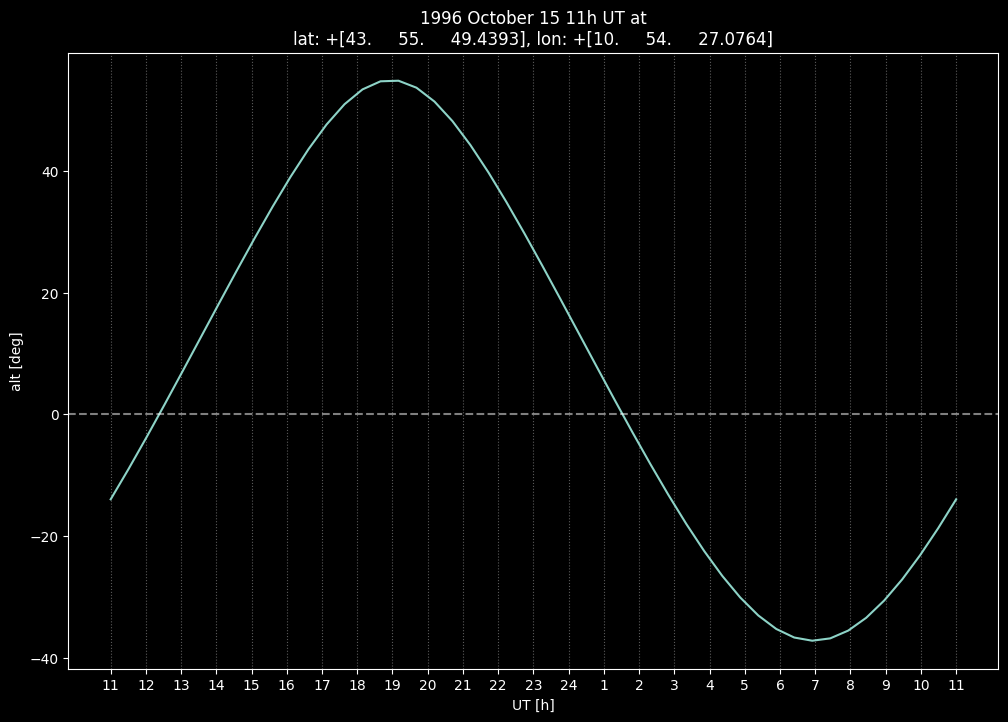

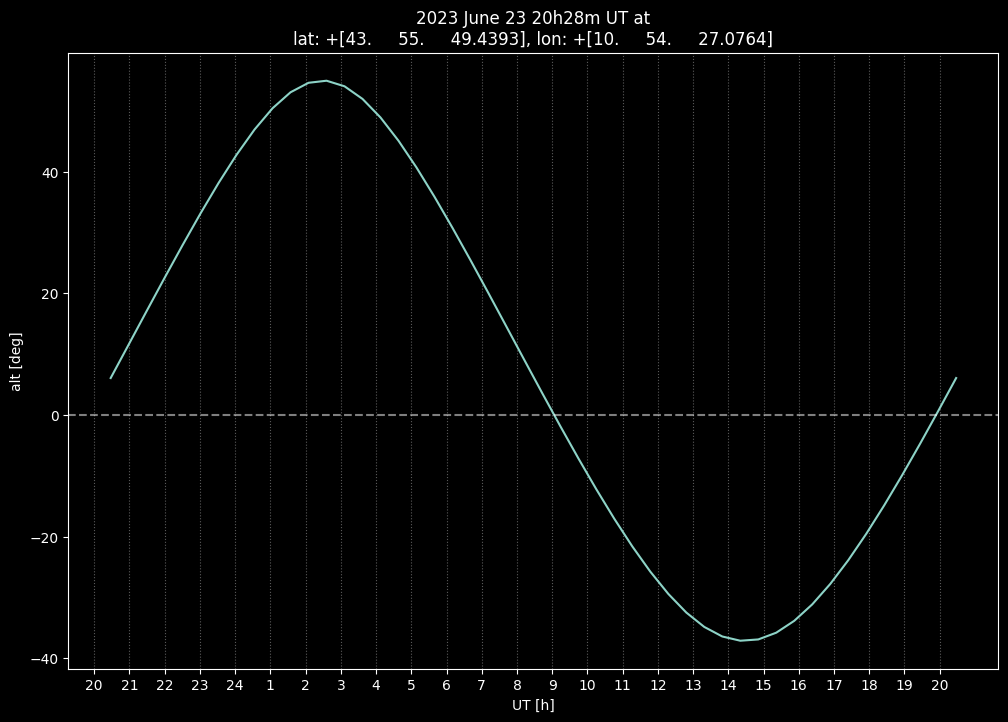

In [210]:






def trajectory(date: Date, obs_pos: GeoPos, eq_pos: Equatorial,  prmt: list | None = None) -> ArrAngle:
    lat = obs_pos.lat
    lon = obs_pos.lon

    ra, dec = precession_corr(date, eq_pos, prmt=prmt)
    
    LST = local_ST(date, lon)
    T = np.linspace(0,24,48) + LST.hms
    alpha = ra.hms
    H = T - alpha
    HA = ArrAngle(H,'hms')

    phi = lat.rad
    delta = dec.rad

    alt = np.arcsin( np.sin(phi)*np.sin(delta) + np.cos(phi)*np.cos(delta) * np.cos(HA.rad)  )

    return ArrAngle(alt,'rad',lim=90)

lat = 43.93039980730644
lon = 10.907521220934262 
h = 65

obs = GeoPos(lon,lat,h)

## 
# print('Vega')
# ra = HAngles(['+',[18,36,56.33635]],'hms')
# dec = HAngles(['+',[38,47,1.2802]],'deg',lim=90)
##

## 
# print('Betelgeuse)
# ra = HAngles(['+',[5,55,10.30536]],'hms')
# dec = HAngles(['+',[7,24,25.4304]],'deg',lim=90)
##

## 
print('Altair')
ra  = HAngles(['+',[19,50,46.99855]],'hms')
dec = HAngles(['+',[8,52,05.9563]],'deg',lim=90)
# proper motion
mu_a = 536.23e-3 # as
mu_d = 385.29e-3 # as
##

obj = Equatorial(ra,dec)
print(obj.print_values())

# ---

date = Date([1996,10,15],[11,0,0])
JDdate = julian_day(date)
alt = trajectory(date,obs,obj,prmt=[mu_a,mu_d])

hour = date.time.hour() 

dayrange = np.array([calendar_date(day/24+JDdate).daydec() for day in np.linspace(0,24,48)])

N = 25 if hour <= (int(hour)+0.5) else 26
ticks = np.arange(0,N,1) + int(hour)

plt.figure(figsize=[12,8])
plt.title(date.str_date() + f" at\nlat: {obs.lat.print_angle('deg')}, lon: {obs.lon.print_angle('deg')}")
plt.plot((dayrange-date.date[-1])*24,alt.deg)
plt.axhline(0,xmin=0,xmax=1,linestyle='dashed',alpha=0.5,)
plt.xticks(ticks,np.where(ticks <= 24, ticks, ticks-24))
plt.xlabel('UT [h]')
plt.ylabel('alt [deg]')
plt.grid(axis='x',linestyle='dotted',color='gray',alpha=0.7)


date = Date([2023,6,23],[20,28,0])
JDdate = julian_day(date)
alt = trajectory(date,obs,obj,prmt=[mu_a,mu_d])

hour = date.time.hour() 

dayrange = np.array([calendar_date(day/24+JDdate).daydec() for day in np.linspace(0,24,48)])

N = 25 if hour <= (int(hour)+0.5) else 26
ticks = np.arange(0,N,1) + int(hour)

plt.figure(figsize=[12,8])
plt.title(date.str_date() + f" at\nlat: {obs.lat.print_angle('deg')}, lon: {obs.lon.print_angle('deg')}")
plt.plot((dayrange-date.date[-1])*24,alt.deg)
plt.axhline(0,xmin=0,xmax=1,linestyle='dashed',alpha=0.5)
plt.xticks(ticks,np.where(ticks <= 24, ticks, ticks-24))
plt.xlabel('UT [h]')
plt.ylabel('alt [deg]')
plt.grid(axis='x',linestyle='dotted',color='gray',alpha=0.7)


plt.show()





## <a id='toc1_4_'></a>[IV. Sun](#toc0_)

### <a id='toc1_4_1_'></a>[IV.I Twilight](#toc0_)

## <a id='toc1_5_'></a>[V. Moon](#toc0_)

### <a id='toc1_5_1_'></a>[V.I Moon Phases](#toc0_)